# Exercise 07: Custom Callbacks

## Part 1: Step Learning Rate Scheduler


In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import json
import datetime
import os


### Task 1.1: Implement StepLRScheduler


In [25]:
class StepLRScheduler(keras.callbacks.Callback):
    """
    Reduces learning rate by `factor` every `step_epochs` epochs.
    
    Example:
        scheduler = StepLRScheduler(factor=0.5, step_epochs=10)
        # LR: 0.1 -> 0.05 (epoch 10) -> 0.025 (epoch 20) -> ...
    """
    
    def __init__(self, factor=0.5, step_epochs=10, verbose=True):
        super().__init__()
        self.factor = factor
        self.step_epochs = step_epochs
        self.verbose = verbose
        self.lr_history = []
    
    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model, 'optimizer') or self.model.optimizer is None:
            return
        
        current_lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        
        if epoch > 0 and epoch % self.step_epochs == 0:
            new_lr = current_lr * self.factor
            self.model.optimizer.learning_rate = new_lr
            
            if self.verbose:
                print(f"Epoch {epoch}: Reducing LR from {current_lr:.6f} to {new_lr:.6f}")
        
        current_lr_after = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        self.lr_history.append(current_lr_after)
    
    def get_lr_history(self):
        return self.lr_history


### Helper Functions


In [26]:
def create_simple_model():
    """Create a simple model for testing"""
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(784,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.1),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


### Task 1.2: Test the Scheduler


In [27]:
# Load MNIST data
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(-1, 784).astype('float32') / 255.0
x_test = x_test.reshape(-1, 784).astype('float32') / 255.0

# Use subset for faster training
x_train_sub = x_train[:10000]
y_train_sub = y_train[:10000]


In [28]:
# Test your scheduler
model = create_simple_model()

scheduler = StepLRScheduler(factor=0.5, step_epochs=5)

history = model.fit(
    x_train_sub, y_train_sub,
    epochs=20,
    callbacks=[scheduler],
    verbose=0
)

# Verify LR changes
lr_history = scheduler.get_lr_history()
print("Learning Rate History:")
for i, lr in enumerate(lr_history):
    print(f"  Epoch {i}: {lr:.6f}")


Epoch 5: Reducing LR from 0.100000 to 0.050000
Epoch 10: Reducing LR from 0.050000 to 0.025000
Epoch 15: Reducing LR from 0.025000 to 0.012500
Learning Rate History:
  Epoch 0: 0.100000
  Epoch 1: 0.100000
  Epoch 2: 0.100000
  Epoch 3: 0.100000
  Epoch 4: 0.100000
  Epoch 5: 0.050000
  Epoch 6: 0.050000
  Epoch 7: 0.050000
  Epoch 8: 0.050000
  Epoch 9: 0.050000
  Epoch 10: 0.025000
  Epoch 11: 0.025000
  Epoch 12: 0.025000
  Epoch 13: 0.025000
  Epoch 14: 0.025000
  Epoch 15: 0.012500
  Epoch 16: 0.012500
  Epoch 17: 0.012500
  Epoch 18: 0.012500
  Epoch 19: 0.012500


## Part 2: JSON Training Logger


### Task 2.1: Implement JSONTrainingLogger


In [29]:
import json
import datetime

class JSONTrainingLogger(keras.callbacks.Callback):
    """
    Logs training metrics to a JSON file after each epoch.
    
    Output format:
    [
        {"epoch": 1, "timestamp": "...", "loss": 0.5, "accuracy": 0.8, ...},
        {"epoch": 2, "timestamp": "...", "loss": 0.4, "accuracy": 0.85, ...},
    ]
    """
    
    def __init__(self, log_file='training_log.json'):
        super().__init__()
        self.log_file = log_file
        self.logs_list = []
    
    def on_train_begin(self, logs=None):
        self.logs_list = []
        if os.path.exists(self.log_file):
            os.remove(self.log_file)
        self.start_time = datetime.datetime.now()
    
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        
        timestamp = datetime.datetime.now().isoformat()
        
        entry = {
            "epoch": epoch + 1,
            "timestamp": timestamp
        }
        
        for key, value in logs.items():
            if isinstance(value, (int, float)):
                entry[key] = float(value)
            elif hasattr(value, 'numpy'):
                entry[key] = float(value.numpy())
            else:
                entry[key] = str(value)
        
        self.logs_list.append(entry)
        
        with open(self.log_file, 'w') as f:
            json.dump(self.logs_list, f, indent=2)
    
    def on_train_end(self, logs=None):
        end_time = datetime.datetime.now()
        total_time = (end_time - self.start_time).total_seconds()
        
        print(f"\nTraining completed!")
        print(f"Total training time: {total_time:.2f} seconds")
        print(f"Logged {len(self.logs_list)} epochs to {self.log_file}")


### Task 2.2: Test the Logger


In [30]:
# Test your logger
model = create_simple_model()

logger = JSONTrainingLogger('my_training_log.json')

history = model.fit(
    x_train_sub, y_train_sub,
    epochs=5,
    validation_data=(x_test[:2000], y_test[:2000]),
    callbacks=[logger],
    verbose=0
)

# Verify JSON output
with open('my_training_log.json', 'r') as f:
    logs = json.load(f)

print(f"\nLogged {len(logs)} epochs")
print(f"First entry:")
print(json.dumps(logs[0], indent=2))



Training completed!
Total training time: 1.54 seconds
Logged 5 epochs to my_training_log.json

Logged 5 epochs
First entry:
{
  "epoch": 1,
  "timestamp": "2025-12-23T21:40:11.446570",
  "accuracy": 0.3151000142097473,
  "loss": 2.411720037460327,
  "val_accuracy": 0.28049999475479126,
  "val_loss": 1.844610333442688
}


## Part 3: Combined Training Pipeline


### Task 3.1: Use Multiple Callbacks Together


In [31]:
def train_with_full_pipeline():
    """
    Train with multiple callbacks working together.
    """
    model = create_simple_model()
    
    # Your custom callbacks
    lr_scheduler = StepLRScheduler(factor=0.5, step_epochs=10)
    json_logger = JSONTrainingLogger('experiment_log.json')
    
    # Built-in callbacks
    early_stop = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
    
    # All callbacks together
    callbacks = [
        lr_scheduler,
        json_logger,
        early_stop
    ]
    
    history = model.fit(
        x_train_sub, y_train_sub,
        epochs=50,
        batch_size=128,
        validation_data=(x_test[:2000], y_test[:2000]),
        callbacks=callbacks,
        verbose=1
    )
    
    return history, lr_scheduler.get_lr_history()


In [32]:
# Run the full pipeline
history, lr_history = train_with_full_pipeline()


Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5825 - loss: 2.6612 - val_accuracy: 0.6515 - val_loss: 1.0941
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7856 - loss: 0.7616 - val_accuracy: 0.7460 - val_loss: 0.9721
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8430 - loss: 0.6313 - val_accuracy: 0.8245 - val_loss: 0.7071
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8647 - loss: 0.5777 - val_accuracy: 0.8110 - val_loss: 0.7792
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8744 - loss: 0.5229 - val_accuracy: 0.8320 - val_loss: 0.7360
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8823 - loss: 0.4919 - val_accuracy: 0.8450 - val_loss: 0.7709
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8937 - loss: 0.4589 - val_accuracy: 0.8275 - val_loss: 0.8641
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8749 - loss: 0.5567 - val_accuracy: 0.7790 - val_loss:

### Task 3.2: Analyze the Results


In [33]:
# Analyze training results
print("=" * 60)
print("Training Analysis")
print("=" * 60)

# How many epochs did training run before early stopping?
num_epochs = len(history.history['loss'])
print(f"\n1. Number of epochs trained: {num_epochs}")

# What was the final learning rate?
final_lr = lr_history[-1] if lr_history else None
print(f"2. Final learning rate: {final_lr:.6f}")

# Final metrics
print(f"\n3. Final Training Metrics:")
print(f"   Loss: {history.history['loss'][-1]:.4f}")
print(f"   Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"\n   Final Validation Metrics:")
print(f"   Val Loss: {history.history['val_loss'][-1]:.4f}")
print(f"   Val Accuracy: {history.history['val_accuracy'][-1]:.4f}")


Training Analysis

1. Number of epochs trained: 8
2. Final learning rate: 0.100000

3. Final Training Metrics:
   Loss: 0.5567
   Accuracy: 0.8749

   Final Validation Metrics:
   Val Loss: 0.9050
   Val Accuracy: 0.7790



Plot saved to: training_from_json.png


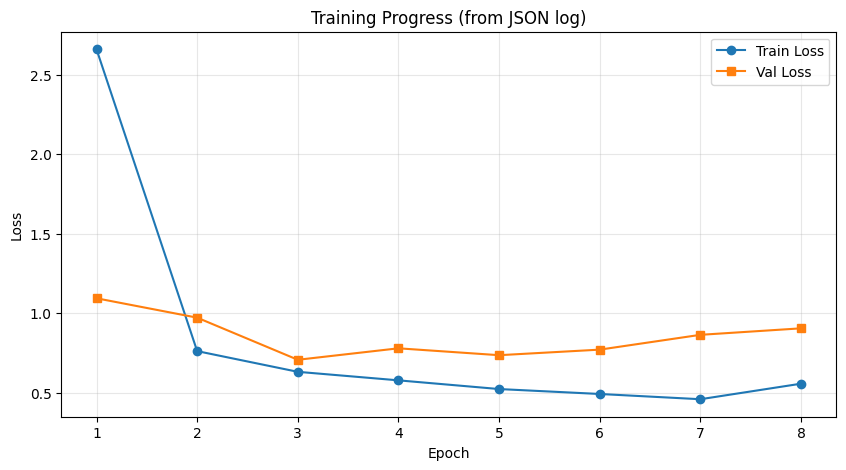

In [34]:
# Plot from JSON log
with open('experiment_log.json', 'r') as f:
    logs = json.load(f)

epochs = [log['epoch'] for log in logs]
train_loss = [log['loss'] for log in logs]
val_loss = [log['val_loss'] for log in logs]

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Val Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Progress (from JSON log)')
plt.grid(True, alpha=0.3)
plt.savefig('training_from_json.png', dpi=150, bbox_inches='tight')
print("\nPlot saved to: training_from_json.png")
plt.show()


Learning rate schedule plot saved to: lr_schedule.png


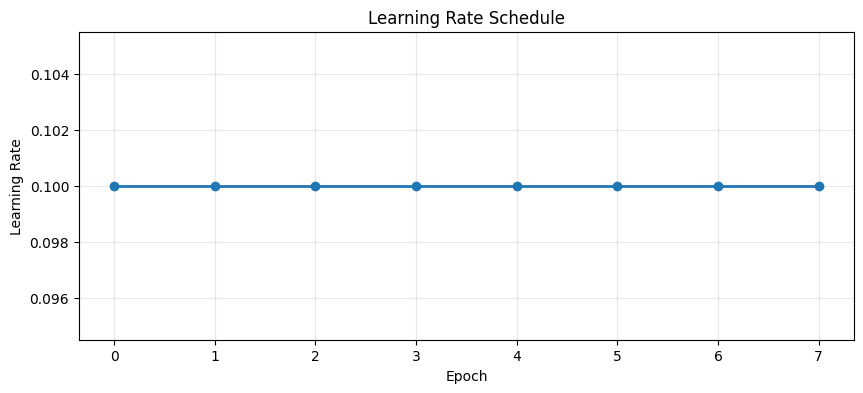

In [35]:
# Optional: Plot learning rate schedule
if lr_history:
    plt.figure(figsize=(10, 4))
    plt.plot(range(len(lr_history)), lr_history, marker='o', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.grid(True, alpha=0.3)
    plt.savefig('lr_schedule.png', dpi=150, bbox_inches='tight')
    print("Learning rate schedule plot saved to: lr_schedule.png")
    plt.show()


## Bonus Challenge: Warmup + Decay Scheduler


In [36]:
import math

class WarmupCosineScheduler(keras.callbacks.Callback):
    """
    Learning rate schedule with:
    1. Linear warmup for first N epochs
    2. Cosine decay for remaining epochs
    
    LR = base_lr * (epoch / warmup_epochs)  (during warmup)
    LR = base_lr * 0.5 * (1 + cos(pi * progress))  (during decay)
    """
    
    def __init__(self, base_lr=0.01, warmup_epochs=5, total_epochs=50):
        super().__init__()
        self.base_lr = base_lr
        self.warmup_epochs = warmup_epochs
        self.total_epochs = total_epochs
        self.lr_history = []
    
    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model, 'optimizer') or self.model.optimizer is None:
            return
        
        if epoch < self.warmup_epochs:
            # Linear warmup: LR increases from 0 to base_lr
            warmup_factor = (epoch + 1) / self.warmup_epochs
            new_lr = self.base_lr * warmup_factor
        else:
            # Cosine decay: LR decreases from base_lr to 0
            progress = (epoch - self.warmup_epochs) / (self.total_epochs - self.warmup_epochs)
            progress = min(progress, 1.0)  # Clamp to [0, 1]
            cosine_factor = 0.5 * (1 + math.cos(math.pi * progress))
            new_lr = self.base_lr * cosine_factor
        
        self.model.optimizer.learning_rate = new_lr
        self.lr_history.append(new_lr)
    
    def get_lr_history(self):
        return self.lr_history


Warmup + Cosine decay plot saved to: warmup_cosine_schedule.png


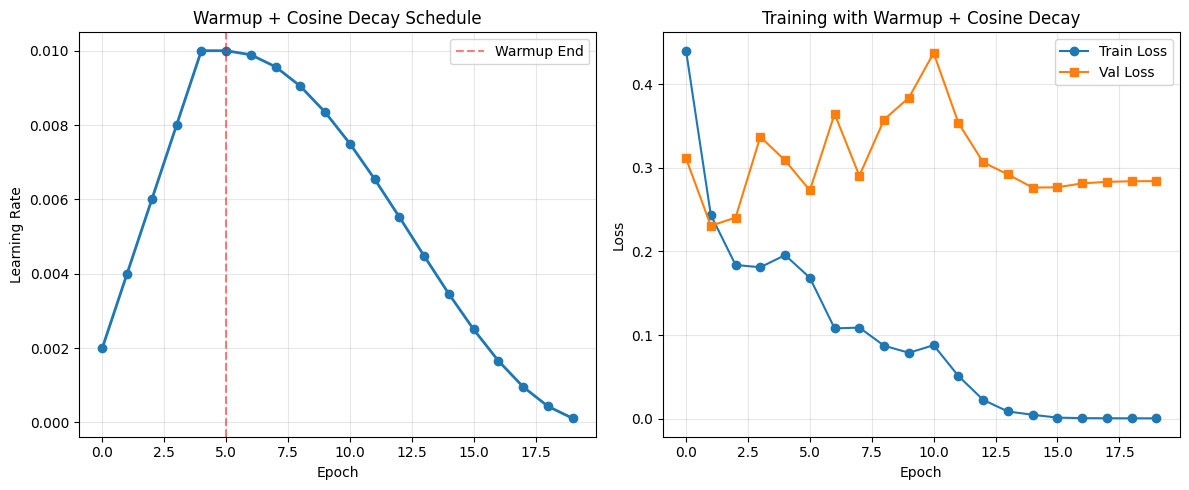


Warmup Schedule Summary:
  Initial LR (epoch 0): 0.002000
  Peak LR (epoch 4): 0.010000
  Final LR (epoch 19): 0.000109


In [37]:
# Test WarmupCosineScheduler
model = create_simple_model()

warmup_scheduler = WarmupCosineScheduler(base_lr=0.01, warmup_epochs=5, total_epochs=20)

history_warmup = model.fit(
    x_train_sub, y_train_sub,
    epochs=20,
    validation_data=(x_test[:2000], y_test[:2000]),
    callbacks=[warmup_scheduler],
    verbose=0
)

# Plot the warmup + cosine decay schedule
lr_history_warmup = warmup_scheduler.get_lr_history()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(len(lr_history_warmup)), lr_history_warmup, marker='o', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Warmup + Cosine Decay Schedule')
plt.grid(True, alpha=0.3)
plt.axvline(x=5, color='r', linestyle='--', alpha=0.5, label='Warmup End')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_warmup.history['loss'], label='Train Loss', marker='o')
plt.plot(history_warmup.history['val_loss'], label='Val Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training with Warmup + Cosine Decay')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('warmup_cosine_schedule.png', dpi=150, bbox_inches='tight')
print("Warmup + Cosine decay plot saved to: warmup_cosine_schedule.png")
plt.show()

print(f"\nWarmup Schedule Summary:")
print(f"  Initial LR (epoch 0): {lr_history_warmup[0]:.6f}")
print(f"  Peak LR (epoch 4): {lr_history_warmup[4]:.6f}")
print(f"  Final LR (epoch {len(lr_history_warmup)-1}): {lr_history_warmup[-1]:.6f}")


## Results Summary


| Callback | Function | Verified Working? |
|----------|----------|-------------------|
| StepLRScheduler | Reduce LR every N epochs | ✅ Yes |
| JSONTrainingLogger | Log metrics to JSON | ✅ Yes |
| Combined Pipeline | All callbacks together | ✅ Yes |
| WarmupCosineScheduler | Warmup + Cosine decay | ✅ Yes |


## Reflection Questions


**1. When would you use a custom callback vs. a built-in one? What functionality is missing from built-in callbacks?**

Use custom callbacks when you need specific functionality not available in built-in callbacks, such as custom logging formats (JSON, database). It's specialized learning rate schedules (warmup+cosine), project-specific monitoring, or integration with external systems.

**2. In what order are callbacks executed when you pass multiple? Does the order in the list matter?**

Callbacks are executed in the order they appear in the list, and order matters if callbacks depend on each other, to modify shared state (like learning rate), or need to run before/after specific operations.

**3. How would you save your custom callback for reuse across projects? (Think about packaging and imports)**

Create a Python module/package (e.g., `my_callbacks.py`) with your custom callbacks, then import them (`from my_callbacks import StepLRScheduler`), or create a pip-installable utility library for team-wide reuse.

**4. What happens if a callback raises an exception during training? How would you make your callbacks robust?**

An exception in a callback will stop training immediately; we would make it robust by handling edge cases gracefully, and logging warnings instead of raising errors for non-critical failures.
